In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import os
import tempfile 


from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, classification_report
from collections import Counter

import tensorflow as tf
import keras


import warnings
warnings.filterwarnings("ignore")
colors = np.array(['#0101DF','#DF0101','#01DF01'])

rs = 42
def compute_metrics (y_te2,y_p,string):
    print('\n %s'%string)
    print('CONFUSION MATRIX')
    print(metrics.confusion_matrix(y_te2,y_p))
    print(classification_report(y_te2, y_p))
    print('\nROC CURVE: %2.2f'%roc_auc_score(y_te2,y_p))

def Ratio10(y,string):
    suma = Counter(y)[0]+Counter(y)[1]
    print('\n'+string)  
    print(Counter(y))
    print('0: %3.2f%%\n1: %3.2f%%' % (100*Counter(y)[0]/suma,100*Counter(y)[1]/suma))

def histo(data,var):
    fig=plt.figure()
    sns.countplot(var,data=data,palette=colors)
    plt.title('0/1 Distribution (0: No Stalling || 1: Stalling Event',fontsize=14)
    plt.show()


Using TensorFlow backend.


Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_cwr',
       'tcp_flag_ecn', 'tcp_flag_urg', 'tcp_flag_psh', 'tcp_flag_rst',
       'tcp_flag_syn', 'tcp_flag_fin', 'tcp_win_si2', 'delay', 'capture',
       'stalling_event'],
      dtype='object')

dataset[stalling_event]
Counter({0: 1426905, 1: 113031})
0: 92.66%
1: 7.34%


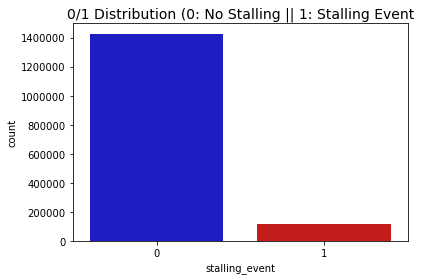

In [2]:
dataset = pd.read_csv('../../output/df_general.csv', sep=',')
split = 0.8
del dataset['No.']
del dataset['Protocol']
del dataset['ip_len']
del dataset['prebuffering']
del dataset['Time']

dataset = dataset.fillna(dataset.mean())
neg, pos = np.bincount(dataset['stalling_event'])

print(dataset.columns)
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

In [3]:
from random import randint
'''X_train = [None] * (len(dataset.columns)-1)
X_test = [None] * (len(dataset.columns)-1)'''

X_train = np.array([None]*12)
X_test = np.array([None]*12)
y_train = list()
y_test = list()

grouped = dataset.groupby(['delay','capture']) 
#print(grouped.mean())

for id, data in grouped:
    spl = int(data.shape[0] * split)
    restspl = int(data.shape[0] * (1-split))
    randnum = randint(0,restspl)
    
    X_train = np.vstack((X_train,data.values[randnum:randnum+spl,:-3]))
    X_test = np.vstack((X_test,data.values[0:randnum-1,:-3]))
    X_test = np.vstack((X_test,data.values[randnum+spl:,:-3]))
    
    y_train.extend(data.values[randnum:randnum+spl,-1])
    y_test.extend(data.values[0:randnum-1,-1])
    y_test.extend(data.values[randnum+spl:,-1])

X_train = X_train[1:]
X_test = X_test[1:]

X_train = pd.DataFrame(data=X_train,columns=dataset.columns[:-3])
X_test= pd.DataFrame(data=X_test,columns=dataset.columns[:-3])
del dataset['delay']
del dataset['capture']

In [4]:
mms = preprocessing.MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [5]:
y_test = list(map(int,y_test))
y_train = list(map(int,y_train))
Ratio10(y_test,'y_test')
Ratio10(y_train,'y_train')


y_test
Counter({0: 302790, 1: 5162})
0: 98.32%
1: 1.68%

y_train
Counter({0: 1124058, 1: 107866})
0: 91.24%
1: 8.76%


In [6]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', 
                                                  verbose=1,
                                                  patience=10,
                                                  mode='max',
                                                  restore_best_weights=True)

In [7]:
n_features = X_train.shape[1]
model = keras.Sequential()
model.add(keras.layers.Dense(16,activation='relu',input_shape=(n_features,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1,activation='sigmoid'))
print('Built NN...')
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
model.summary()
print('Compiled NN...')

Built NN...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                208       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
Compiled NN...


In [8]:
model.predict(X_train[:10])
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

1231924/1231924 [==============================] - 6s 5us/step

In [9]:
initial_bias = np.log([pos/neg])
print(initial_bias)

[-2.53560092]


In [10]:
model = keras.Sequential()
model.add(keras.layers.Dense(16,activation='relu',input_shape=(n_features,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1,activation='sigmoid',bias_initializer=keras.initializers.Constant(initial_bias)))
print('Built NN...')
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
model.summary()
print('Compiled NN...')

Built NN...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                208       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
Compiled NN...


In [11]:
model.predict(X_train[:10])
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))


1231924/1231924 [==============================] - 5s 4us/step

In [12]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [13]:
model = keras.Sequential()
model.add(keras.layers.Dense(16,activation='relu',input_shape=(n_features,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1,activation='sigmoid'))
print('Built NN...')
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
model.summary()
print('Compiled NN...')

model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(X_train,
                              y_train,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_split=0.2, 
                              verbose=1)

Built NN...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                208       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
Compiled NN...
Train on 985539 samples, validate on 246385 samples
Epoch 1/20
985539/985539 [=================

In [14]:
model = keras.Sequential()
model.add(keras.layers.Dense(16,activation='relu',input_shape=(n_features,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1,activation='sigmoid'))
print('Built NN...')
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
model.summary()
print('Compiled NN...')
model.load_weights(initial_weights)
careful_bias_history = model.fit(X_train,
                                 y_train,
                                 batch_size=BATCH_SIZE,
                                 epochs=20,
                                 validation_split=0.2, 
                                 verbose=1)

Built NN...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                208       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
Compiled NN...
Train on 985539 samples, validate on 246385 samples
Epoch 1/20
985539/985539 [=================

In [15]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  
                 history.history['loss'],
                 color=colors[n], 
                 label='Train '+label
                 )
    plt.semilogy(history.epoch,
                 history.history['val_loss'],
                 color=colors[n], 
                 label='Val '+label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

<function matplotlib.pyplot.show(*args, **kw)>

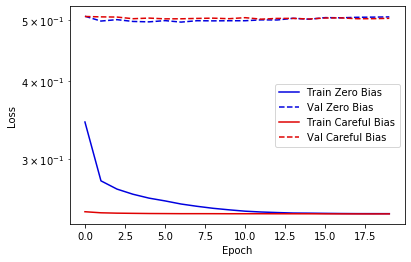

In [16]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)
plt.show

In [17]:
model = keras.Sequential()
model.add(keras.layers.Dense(16,activation='relu',input_shape=(n_features,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1,activation='sigmoid'))
print('Built NN...')
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
model.summary()
print('Compiled NN...')

baseline_history = model.fit(X_train,
                             y_train,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks = [early_stopping],
                             validation_split=0.2
                             )

Built NN...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                208       
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
Compiled NN...
Train on 985539 samples, validate on 246385 samples
Epoch 1/100
985539/985539 [================

In [18]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.5,1])
        else:
            plt.ylim([0,1])

    plt.legend()
    

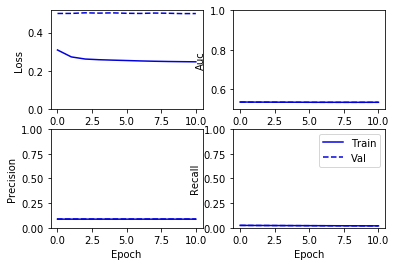

In [19]:
plot_metrics(baseline_history)
plt.show()

In [20]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)
print(test_predictions_baseline[:5])

[[0.1679171 ]
 [0.13293439]
 [0.06048608]
 [0.06642404]
 [0.08441314]]


In [21]:
def plot_cm(labels, predictions, p=0.5):
  cm = metrics.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))
  

In [22]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

loss :  0.11540508755226907
tp :  111110.9921875
fp :  1159009.5
tn :  58566980.0
fn :  5610113.0
accuracy :  0.8965670466423035
precision :  0.08748055249452591
recall :  0.019420839846134186
auc :  0.5351040959358215



Legitimate Transactions Detected (True Negatives):  302790
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  5162
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  5162


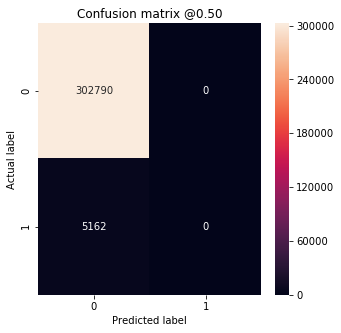

In [23]:
plot_cm(y_test, test_predictions_baseline)

In [24]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

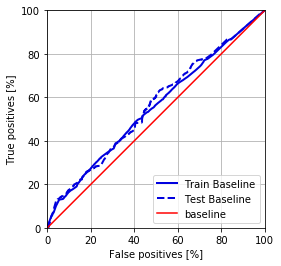

In [25]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.plot([0,100],[0,100],label='baseline',c='red')
plt.legend(loc='lower right')
plt.xlim([0,100])
plt.ylim([0,100])
plt.show()